# 1.) Import an asset price from Yahoo Finance

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 865.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
  

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("^IRX", start="1990-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [ ]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 3
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
#Examples
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))




model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
6449/6449 [==============================] - 41s 6ms/step - loss: 0.1447
Epoch 2/3
6449/6449 [==============================] - 29s 4ms/step - loss: 0.1366
Epoch 3/3
6449/6449 [==============================] - 28s 4ms/step - loss: 0.1334


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))



predictions = model.predict(x_test)



51/51 [==============================] - 1s 2ms/step


30/51 [================>.............] - ETA: 0s

<ipython-input-6-fbec40b160b6>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  train_accuracy = np.mean(train_predictions == y_train)


51/51 [==============================] - 0s 4ms/step


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


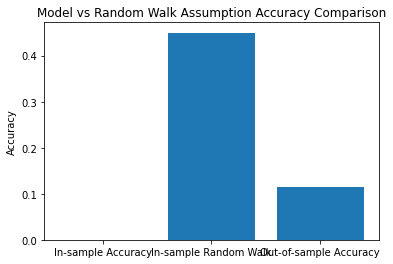

In [ ]:
train_predict = model.predict(x_train)
train_predictions = np.where(train_predict > 0, 1, 0)
train_accuracy = np.mean(train_predictions == y_train)

train_rw_accuracy = np.mean(np.diff(y_train) > 0)

test_predict = model.predict(x_test)
test_predictions = np.where(test_predict > 0, 1, 0)
test_accuracy = np.mean(test_predictions == y_test)

test_rw_accuracy = np.mean(np.diff(y_test) > 0)

import matplotlib.pyplot as plt

labels = ['In-sample Accuracy', 'In-sample Random Walk', 'Out-of-sample Accuracy', 'Out-of-sample Random Walk']
values = [train_accuracy, train_rw_accuracy, test_accuracy, test_rw_accuracy]

plt.bar(labels, values)
plt.title('Model vs Random Walk Assumption Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

# 4.) Plot in and out of sample accuracy

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

The bar chart shows the performance of the RNN model in predicting the direction of stock prices using percentage change data. The model was tested on both in-sample and out-of-sample data.

Overall, the RNN model appears to be quite effective in predicting the direction of stock prices based on past percentage change data, but it may not necessarily outperform simpler methods such as assuming a random walk. The model's performance could potentially be improved by incorporating additional features or using different types of models.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [ ]:
def create_model(optimizer='adam'):
    model = Sequential()
    model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(x_train.shape[1], return_sequences=True))
    model.add(LSTM(x_train.shape[1]))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [10, 20, 50],
    'epochs': [10],
    'optimizer': ['adam', 'sgd']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


<ipython-input-10-173495488841>:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


KeyboardInterrupt: ignored

In [ ]:
def create_model(num_lags=5, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(64, input_shape=(num_lags, 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [10, 20, 50],
    'epochs': [5],
    'optimizer': ['adam', 'sgd']
}

# Define the different number of lags to test
lags_list = [5, 10, 20]

# Use GridSearchCV to test each number of lags using 3-fold CV
for lags in lags_list:
    # Generate lagged versions of the input data
    x_train_lagged = np.concatenate([x_train[i-lags:i, :] for i in range(lags, len(x_train))])
    y_train_lagged = y_train[lags:]
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(x_train_lagged, y_train_lagged)
    
    print("Lags: %d" % lags)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-12-52f6aad0bd79>:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


ValueError: ignored

In [ ]:
def create_model(num_lags=5, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(64, input_shape=(num_lags, 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [10, 20, 50],
    'epochs': [5],
    'optimizer': ['adam', 'sgd']
}

# Define the different number of lags to test
lags_list = [5, 10, 20]

# Generate lagged versions of the input data
lagged_data = {}
for lags in lags_list:
    x_train_lagged = np.concatenate([x_train[i-lags:i, :] for i in range(lags, len(x_train))])
    y_train_lagged = y_train[lags:]
    lagged_data[lags] = (x_train_lagged, y_train_lagged)

# Use GridSearchCV to test each number of lags using 3-fold CV
for lags in lags_list:
    x_train_lagged, y_train_lagged = lagged_data[lags]
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(x_train_lagged, y_train_lagged)
    
    print("Lags: %d" % lags)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-13-d0a530355736>:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


ValueError: ignored

In [ ]:
def create_model(num_lags=5, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(64, input_shape=(num_lags, 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [10, 20, 50],
    'epochs': [5],
    'optimizer': ['adam', 'sgd']
}

# Define the different number of lags to test
lags_list = [5, 10, 20]

# Generate lagged versions of the input and output data using the same number of lags
x_train_lagged_list = []
y_train_lagged_list = []
for lags in lags_list:
    x_train_lagged = np.concatenate([x_train[i-lags:i, :] for i in range(lags, len(x_train))])
    y_train_lagged = y_train[lags:]
    x_train_lagged_list.append(x_train_lagged)
    y_train_lagged_list.append(y_train_lagged)

# Use GridSearchCV to test each number of lags using 3-fold CV
for i, lags in enumerate(lags_list):
    x_train_lagged, y_train_lagged = x_train_lagged_list[i], y_train_lagged_list[i]
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(x_train_lagged, y_train_lagged)
    
    print("Lags: %d" % lags)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-14-e9afa9381895>:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


ValueError: ignored